Initial Mass: 1.00000
Final Mass:   1.42640
Diff:         4.26e-01


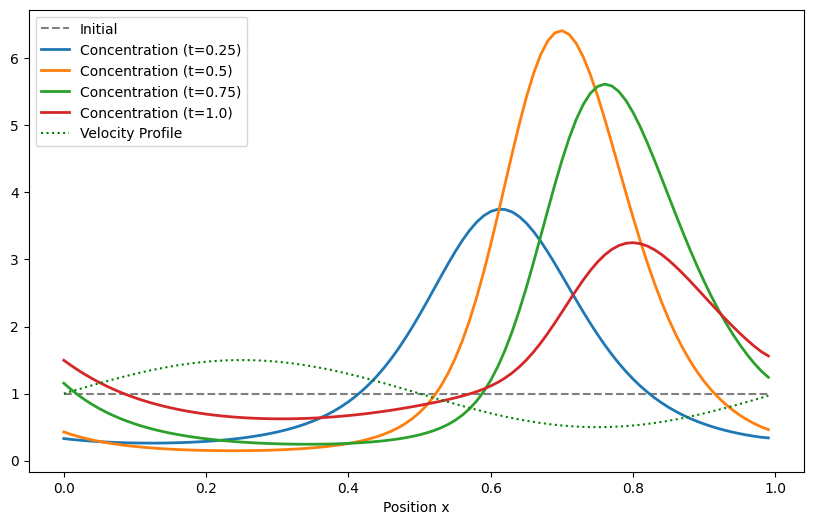

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse

# --- 1. Parameters ---
L = 1.0             
Nx = 100            
T = 1.0             
D = 0.01           
# a = 0.5 # reaction             

dx = L / Nx  
x = np.linspace(0, L, Nx, endpoint=False) # Points 0 to N-1

# Variable Velocity
P = 1.0 #period
c_0 = 1.0
c_1 = 0.5
c = c_0 + c_1 * np.sin( 2*np.pi / P * x)
c_x =  2*np.pi / P * c_1 * np.cos(2*np.pi / P *x)

#
dt = 0.01 * dx / (c_0+c_1)
Nt = int(T / dt)


# --- 3. Constructing Sparse Matrix 
alpha = c / (2 * dx)
beta = D / dx**2

# A. Main Diagonal (i)
main_diag = 1.0 - dt * (2*beta) - dt * c_x

# B. Lower Diagonal (i-1)
# Coefficient: beta + alpha
lower_diag = dt * (beta + alpha)

# C. Upper Diagonal (i+1)
upper_diag = dt * (beta - alpha) # Note: alpha is an array, beta is scalar

data = np.array([upper_diag, main_diag, lower_diag])
offsets = [1, 0, -1]
A = sparse.spdiags(data, offsets, Nx, Nx, format='lil')

# E. Periodic Corners
# Top-Right (0, N-1): Behaves like a "Left Neighbor" (Lower Diag logic)
A[0, Nx-1] = dt * (beta + alpha[0])

# Bottom-Left (N-1, 0): Behaves like a "Right Neighbor" (Upper Diag logic)
A[Nx-1, 0] = dt * (beta - alpha[-1])

A_csr = A.tocsr()

# --- 4. Simulation ---
u = np.ones(Nx) #np.exp(-100 * (x - 0.25)**2)
history = [u.copy()]
plot_every = Nt // 4

for n in range(Nt):
    u = A_csr.dot(u)
    if n % plot_every==0 and n!=0:
        history.append(u.copy())

initial_mass = np.sum(history[0]) * dx
final_mass = np.sum(u) * dx
print(f"Initial Mass: {initial_mass:.5f}")
print(f"Final Mass:   {final_mass:.5f}")
print(f"Diff:         {final_mass - initial_mass:.2e}")

# --- 5. Visualization ---
plt.figure(figsize=(10,6))

plt.plot(x, history[0], 'k--', alpha=0.5, label='Initial')
plt.plot(x, history[1], linewidth=2, label=f'Concentration (t={T/4})')
plt.plot(x, history[2], linewidth=2, label=f'Concentration (t={T/2})')
plt.plot(x, history[3], linewidth=2, label=f'Concentration (t={3/4*T})')
plt.plot(x, u,  linewidth=2, label=f'Concentration (t={T})')

# Plot Velocity (scaled)
c_scaled = (c / np.mean(c)) 
plt.plot(x, c_scaled, 'g:', label='Velocity Profile')

plt.xlabel('Position x')
plt.legend()
plt.show()






